<a href="https://colab.research.google.com/github/swilsonmfc/pandas/blob/main/11_Lesson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GeoSpatial Analysis with Pandas

# Install

In [ ]:
!pip install geopandas
!pip install rtree
!pip install contextily
!pip install country_converter

     |████████████████████████████████| 994 kB 5.4 MB/s 
     |████████████████████████████████| 6.3 MB 40.0 MB/s 
     |████████████████████████████████| 15.4 MB 34 kB/s 
     |████████████████████████████████| 994 kB 5.1 MB/s 
     |████████████████████████████████| 19.3 MB 1.2 MB/s 
     |████████████████████████████████| 49 kB 2.8 MB/s 
  Created wheel for country-converter: filename=country_converter-0.7.3-py3-none-any.whl size=52304 sha256=323d5f2a4006ab4a420e31e7c0d9fc74c8bad52b430ee7cb68cb7297f7214ed7
  Stored in directory: /root/.cache/pip/wheels/2e/d9/03/664296e7e90b85b7e8ffca3af6cacdb299eec3929d62746505
Successfully built country-converter


# Setup

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas
import contextily as ctx
import country_converter as coco

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer

from mpl_toolkits.axes_grid1 import make_axes_locatable

# NYC Data

In [ ]:
path_to_data = geopandas.datasets.get_path("nybb")
nyc_df = geopandas.read_file(path_to_data)
nyc_df

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
0,5,Staten Island,330470.010332,1.623820e+09,"MULTIPOLYGON (((970217.022 145643.332, 970227...."
1,4,Queens,896344.047763,3.045213e+09,"MULTIPOLYGON (((1029606.077 156073.814, 102957..."
2,3,Brooklyn,741080.523166,1.937479e+09,"MULTIPOLYGON (((1021176.479 151374.797, 102100..."
3,1,Manhattan,359299.096471,6.364715e+08,"MULTIPOLYGON (((981219.056 188655.316, 980940...."
4,2,Bronx,464392.991824,1.186925e+09,"MULTIPOLYGON (((1012821.806 229228.265, 101278..."


## Exploring 
* Geopandas extends a dataframe with helpful geospatial analysis tools

In [ ]:
# Geopandas frames are frames + geometry
nyc_df.geometry

0    MULTIPOLYGON (((970217.022 145643.332, 970227....
1    MULTIPOLYGON (((1029606.077 156073.814, 102957...
2    MULTIPOLYGON (((1021176.479 151374.797, 102100...
3    MULTIPOLYGON (((981219.056 188655.316, 980940....
4    MULTIPOLYGON (((1012821.806 229228.265, 101278...
Name: geometry, dtype: geometry

In [ ]:
# Boundary of geometry
nyc_df.boundary

0    MULTILINESTRING ((970217.022 145643.332, 97022...
1    MULTILINESTRING ((1029606.077 156073.814, 1029...
2    MULTILINESTRING ((1021176.479 151374.797, 1021...
3    MULTILINESTRING ((981219.056 188655.316, 98094...
4    MULTILINESTRING ((1012821.806 229228.265, 1012...
dtype: geometry

In [ ]:
# Bounding Box
nyc_df.bounds

,minx,miny,maxx,maxy
0,9.131751e+05,120121.881254,9.705701e+05,175708.962036
1,9.946086e+05,136681.776184,1.067383e+06,231157.996399
2,9.726197e+05,146772.031799,1.030453e+06,208564.104004
3,9.710135e+05,188082.322388,1.010066e+06,259547.770386
4,1.002623e+06,225426.884583,1.049167e+06,272844.293640


In [ ]:
# Frame bounding box
nyc_df.total_bounds

array([ 913175.10900879,  120121.88125434, 1067382.50842285,
        272844.29364014])

In [ ]:
# Area of geometry
nyc_df.area

0    1.623822e+09
1    3.045214e+09
2    1.937478e+09
3    6.364712e+08
4    1.186926e+09
dtype: float64

In [ ]:
# Centroid of geometry
nyc_df.centroid

0     POINT (941639.450 150931.991)
1    POINT (1034578.078 197116.604)
2     POINT (998769.115 174169.761)
3     POINT (993336.965 222451.437)
4    POINT (1021174.790 249937.980)
dtype: geometry

## Plotting

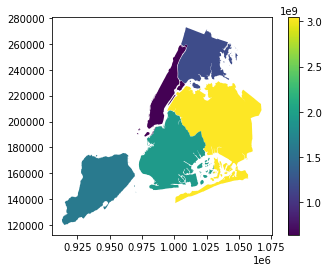

In [ ]:
# Plot on map
nyc_df['area'] = nyc_df.area
nyc_df.plot('area', legend=True);

In [ ]:
# You can have multiple "geometries", but only one active on the frame
# Call set_geometry to change
nyc_df['centroids'] = nyc_df.centroid
nyc_df = nyc_df.set_geometry('centroids')
nyc_df.geometry

0     POINT (941639.450 150931.991)
1    POINT (1034578.078 197116.604)
2     POINT (998769.115 174169.761)
3     POINT (993336.965 222451.437)
4    POINT (1021174.790 249937.980)
Name: centroids, dtype: geometry

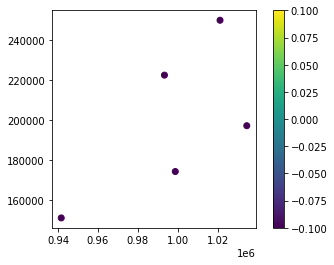

In [ ]:
# Plot on map 
# Note - plot is using the centroid locations
nyc_df['area'] = nyc_df.area
nyc_df.plot('area', legend=True);

# Airports

In [ ]:
# Pull down an airport dataset
!wget -O airports.zip https://www.partow.net/downloads/GlobalAirportDatabase.zip
!unzip airports.zip

--2021-09-22 11:22:14--  https://www.partow.net/downloads/GlobalAirportDatabase.zip
Resolving www.partow.net (www.partow.net)... 173.236.154.120
Connecting to www.partow.net (www.partow.net)|173.236.154.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 202651 (198K) [application/zip]
Saving to: ‘airports.zip’

airports.zip        100%[===================>] 197.90K  --.-KB/s    in 0.06s   

2021-09-22 11:22:14 (3.31 MB/s) - ‘airports.zip’ saved [202651/202651]

Archive:  airports.zip
  inflating: GlobalAirportDatabase.txt  
  inflating: readme.txt              


In [ ]:
# Doesn't have columns, add them
columns = [
  'icao',
  'iata', 
  'name',
  'city',
  'country',
  'lat_degrees',
  'lat_minutes',
  'lat_seconds',
  'lat_direction',
  'lon_degrees',
  'lon_minutes',
  'lon_seconds',
  'lon_direction',
  'alt',
  'lat',
  'lon'
]

In [ ]:
# Read the airports from file
airports_df = pd.read_csv('GlobalAirportDatabase.txt', header=None, sep=':', names=columns)
airports_df

,icao,iata,name,city,country,lat_degrees,lat_minutes,lat_seconds,lat_direction,lon_degrees,lon_minutes,lon_seconds,lon_direction,alt,lat,lon
0,AYGA,GKA,GOROKA,GOROKA,PAPUA NEW GUINEA,6,4,54,S,145,23,30,E,1610,-6.082,145.392
1,AYLA,LAE,NaN,LAE,PAPUA NEW GUINEA,0,0,0,U,0,0,0,U,0,0.000,0.000
2,AYMD,MAG,MADANG,MADANG,PAPUA NEW GUINEA,5,12,25,S,145,47,19,E,7,-5.207,145.789
3,AYMH,HGU,MOUNT HAGEN,MOUNT HAGEN,PAPUA NEW GUINEA,5,49,34,S,144,17,46,E,1643,-5.826,144.296
4,AYNZ,LAE,NADZAB,NADZAB,PAPUA NEW GUINEA,6,34,11,S,146,43,34,E,73,-6.570,146.726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9295,ZYTK,NaN,NaN,SHENYANG,CHINA,0,0,0,U,0,0,0,U,0,0.000,0.000
9296,ZYTL,DLC,ZHOUSHUIZI,DALIAN,CHINA,38,57,56,N,121,32,18,E,33,38.966,121.538
9297,ZYXC,NaN,NaN,XIANCHENG,CHINA,0,0,0,U,0,0,0,U,0,0.000,0.000
9298,ZYYC,NaN,NaN,YICHUN,CHINA,0,0,0,U,0,0,0,U,0,0.000,0.000


In [ ]:
# Convert to geopandas frame
airports_geo_df = geopandas.GeoDataFrame(airports_df, 
  geometry=geopandas.points_from_xy(airports_df.lon, airports_df.lat))
airports_geo_df

,icao,iata,name,city,country,lat_degrees,lat_minutes,lat_seconds,lat_direction,lon_degrees,lon_minutes,lon_seconds,lon_direction,alt,lat,lon,geometry
0,AYGA,GKA,GOROKA,GOROKA,PAPUA NEW GUINEA,6,4,54,S,145,23,30,E,1610,-6.082,145.392,POINT (145.39200 -6.08200)
1,AYLA,LAE,NaN,LAE,PAPUA NEW GUINEA,0,0,0,U,0,0,0,U,0,0.000,0.000,POINT (0.00000 0.00000)
2,AYMD,MAG,MADANG,MADANG,PAPUA NEW GUINEA,5,12,25,S,145,47,19,E,7,-5.207,145.789,POINT (145.78900 -5.20700)
3,AYMH,HGU,MOUNT HAGEN,MOUNT HAGEN,PAPUA NEW GUINEA,5,49,34,S,144,17,46,E,1643,-5.826,144.296,POINT (144.29600 -5.82600)
4,AYNZ,LAE,NADZAB,NADZAB,PAPUA NEW GUINEA,6,34,11,S,146,43,34,E,73,-6.570,146.726,POINT (146.72600 -6.57000)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9295,ZYTK,NaN,NaN,SHENYANG,CHINA,0,0,0,U,0,0,0,U,0,0.000,0.000,POINT (0.00000 0.00000)
9296,ZYTL,DLC,ZHOUSHUIZI,DALIAN,CHINA,38,57,56,N,121,32,18,E,33,38.966,121.538,POINT (121.53800 38.96600)
9297,ZYXC,NaN,NaN,XIANCHENG,CHINA,0,0,0,U,0,0,0,U,0,0.000,0.000,POINT (0.00000 0.00000)
9298,ZYYC,NaN,NaN,YICHUN,CHINA,0,0,0,U,0,0,0,U,0,0.000,0.000,POINT (0.00000 0.00000)


## Plot

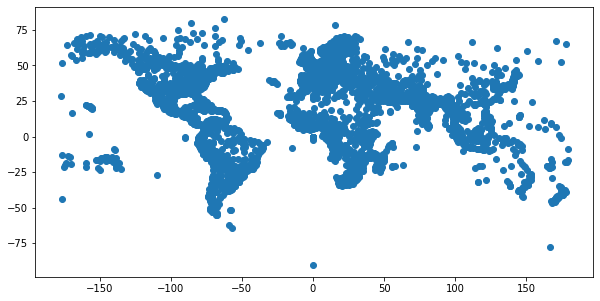

In [ ]:
# Plot each airport
airports_geo_df.plot(figsize=(10, 10));

In [ ]:
# Large number of airports without lat / lon
airports_geo_df[airports_geo_df.lon_direction == 'U']

,icao,iata,name,city,country,lat_degrees,lat_minutes,lat_seconds,lat_direction,lon_degrees,lon_minutes,lon_seconds,lon_direction,alt,lat,lon,geometry
1,AYLA,LAE,NaN,LAE,PAPUA NEW GUINEA,0,0,0,U,0,0,0,U,0,0.0,0.0,POINT (0.00000 0.00000)
6,AYRB,RAB,NaN,RABAUL,PAPUA NEW GUINEA,0,0,0,U,0,0,0,U,0,0.0,0.0,POINT (0.00000 0.00000)
8,BGAM,NaN,NaN,ANGMAGSSALIK,GREENLAND,0,0,0,U,0,0,0,U,0,0.0,0.0,POINT (0.00000 0.00000)
9,BGAS,NaN,NaN,ANGISSOQ,GREENLAND,0,0,0,U,0,0,0,U,0,0.0,0.0,POINT (0.00000 0.00000)
10,BGAT,NaN,NaN,APUTITEQ,GREENLAND,0,0,0,U,0,0,0,U,0,0.0,0.0,POINT (0.00000 0.00000)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9293,ZYRD,CGQ,NaN,CHANGCHUN,CHINA,0,0,0,U,0,0,0,U,0,0.0,0.0,POINT (0.00000 0.00000)
9294,ZYTH,NaN,NaN,TAHE,CHINA,0,0,0,U,0,0,0,U,0,0.0,0.0,POINT (0.00000 0.00000)
9295,ZYTK,NaN,NaN,SHENYANG,CHINA,0,0,0,U,0,0,0,U,0,0.0,0.0,POINT (0.00000 0.00000)
9297,ZYXC,NaN,NaN,XIANCHENG,CHINA,0,0,0,U,0,0,0,U,0,0.0,0.0,POINT (0.00000 0.00000)


## Attribute Join

In [ ]:
# Read world shapes into a geopandas frame
world_df = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world_df

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
...,...,...,...,...,...,...
172,7111024,Europe,Serbia,SRB,101800.0,"POLYGON ((18.82982 45.90887, 18.82984 45.90888..."
173,642550,Europe,Montenegro,MNE,10610.0,"POLYGON ((20.07070 42.58863, 19.80161 42.50009..."
174,1895250,Europe,Kosovo,-99,18490.0,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."
175,1218208,North America,Trinidad and Tobago,TTO,43570.0,"POLYGON ((-61.68000 10.76000, -61.10500 10.890..."


In [ ]:
# Types in the frame
world_df.dtypes

pop_est          int64
continent       object
name            object
iso_a3          object
gdp_md_est     float64
geometry      geometry
dtype: object

In [ ]:
# We'd like to summarize the number of airports under the geometry of the
# world data frame, to do that we need a join key -- countries
def map_countries(world, airport):
  mapping = {}
  for c in world.intersection(airport):
    mapping[c] = c

  for c in sorted(airport):
    if c not in mapping:
      print('airport', c)

  for c in sorted(world):
    if c not in mapping:
      print('world', c)
  
  return mapping

In [ ]:
# First try - How much work remains?
world_countries = set(world_df.name.str.lower())
airport_countries = set(airports_geo_df.country.str.lower())

mapped = map_countries(world_countries, airport_countries)
print(len(mapped))

airport acores
airport anguilla isl.
airport antigua & barbuda
airport antilles
airport aruba
airport bahrain
airport baker i island
airport barbados
airport bophuthatswana
airport bosnia-hercegovina
airport canary islands
airport cape verde islands
airport cayman islands
airport christmas island
airport comoros islands
airport cook islands
airport corse isl.
airport czech republic
airport diego garcia island
airport dominica
airport dominican republic
airport east timor
airport engalnd
airport england
airport equatorial guinea
airport falkland islands
airport faroe isl.
airport former macedonia
airport french guyana
airport french polynesia
airport galapagos i. (ecuador
airport gibraltar
airport grenada
airport guadeloupe
airport guernsey isld.
airport guinea bissau
airport hong kong
airport ivory coast
airport johnston atoll
airport kiribati
airport korea
airport leeward islands
airport line islands
airport luxemburg
airport macau
airport madeira
airport maldives
airport malta
airpor

In [ ]:
# Second try - using a library to help
world_standardized   = set(coco.convert(names=world_countries, to='name_short'))
airport_standardized = set(coco.convert(names=airport_countries, to='name_short'))

mapped = map_countries(world_standardized, airport_standardized)
print(len(mapped))

s. sudan not found in regex
fr. s. antarctic lands not found in regex
occidental sahara not found in regex
scotland not found in regex
canary islands not found in regex
wales not found in regex
engalnd not found in regex
west timor not found in regex
virgin isl. not found in regex
corse isl. not found in regex
wake island not found in regex
baker i island not found in regex
tuamotu islands not found in regex
shetland island not found in regex
leeward islands not found in regex
diego garcia island not found in regex
north ireland not found in regex
line islands not found in regex
england not found in regex
antilles not found in regex
madeira not found in regex
bophuthatswana not found in regex
spanish north africa not found in regex
acores not found in regex
uk not found in ISO2
yugoslavia not found in regex
johnston atoll not found in regex
phoenix isl. not found in regex
midway island not found in regex


airport Anguilla
airport Antigua and Barbuda
airport Aruba
airport Bahrain
airport Barbados
airport Cabo Verde
airport Cayman Islands
airport Christmas Island
airport Comoros
airport Cook Islands
airport Dominica
airport Faeroe Islands
airport French Polynesia
airport Gibraltar
airport Grenada
airport Guadeloupe
airport Guernsey
airport Hong Kong
airport Kiribati
airport Macau
airport Maldives
airport Malta
airport Marshall Islands
airport Mauritius
airport Mayotte
airport Micronesia, Fed. Sts.
airport Monaco
airport Montserrat
airport Nauru
airport Northern Mariana Islands
airport Palau
airport Reunion
airport Samoa
airport Sao Tome and Principe
airport Seychelles
airport Singapore
airport St. Kitts and Nevis
airport St. Lucia
airport St. Pierre and Miquelon
airport St. Vincent and the Grenadines
airport Tonga
airport Turks and Caicos Islands
airport Tuvalu
airport Wallis and Futuna Islands
world Armenia
world Azerbaijan
world Belarus
world Eritrea
world Kosovo
world Kyrgyz Republic
w

In [ ]:
# Copy Airports
airports_df = airports_geo_df.copy()

# Manually Fix ... 
fixes = [
  ('ENGLAND',          'United Kingdom'),
  ('UK',               'United Kingdom'),
  ('NORTH IRELAND',    'United Kingdom'),
  ('WALES',            'United Kingdom'),
  ('SCOTLAND',         'United Kingdom'),
  ('SHETLAND ISLANDS', 'Uniked Kingdom'),
  ('CANARY ISLANDS',   'Spain'),
  ('ACORES',           'Portugal'),
  ('CORSE ISL.',       'Spain'),
  ('ANTILLES',         'Netherlands')
]
for fix in fixes:
  world_df['name'] = np.where(world_df.name == fix[0], fix[1], world_df.name)
  airports_df['country'] = np.where(airports_df.country == fix[0], fix[1], airports_df.country)

In [ ]:
# Standardize Country
world_df['standardized']   = coco.convert(names=world_df.name, to='name_short')
world_df = world_df.dropna(subset=['standardized'])

# Standard Airport
airports_df['standardized'] = coco.convert(names=airports_df.country, to='name_short')
airports_df = airports_df.dropna(subset=['standardized'])
airports_df = airports_df.groupby('standardized').size().reset_index().rename(columns={0:'airports'})

# Join where we have matches -- map unknowns for better performance
joined_df = pd.merge(world_df, airports_df, on='standardized', suffixes=('_world', '_airport'))

Fr. S. Antarctic Lands not found in regex
S. Sudan not found in regex
ENGALND not found in regex
SHETLAND ISLAND not found in regex
BOPHUTHATSWANA not found in regex
DIEGO GARCIA ISLAND not found in regex
SPANISH NORTH AFRICA not found in regex
SPANISH NORTH AFRICA not found in regex
OCCIDENTAL SAHARA not found in regex
OCCIDENTAL SAHARA not found in regex
MADEIRA not found in regex
MADEIRA not found in regex
YUGOSLAVIA not found in regex
YUGOSLAVIA not found in regex
YUGOSLAVIA not found in regex
YUGOSLAVIA not found in regex
YUGOSLAVIA not found in regex
YUGOSLAVIA not found in regex
YUGOSLAVIA not found in regex
YUGOSLAVIA not found in regex
TUAMOTU ISLANDS not found in regex
TUAMOTU ISLANDS not found in regex
TUAMOTU ISLANDS not found in regex
TUAMOTU ISLANDS not found in regex
TUAMOTU ISLANDS not found in regex
TUAMOTU ISLANDS not found in regex
WAKE ISLAND not found in regex
BAKER I ISLAND not found in regex
PHOENIX ISL. not found in regex
JOHNSTON ATOLL not found in regex
LINE I

## Spatial Joins

In [ ]:
# Spatial Joins need to be in the same projection
airports_geo_df = airports_geo_df.set_crs(epsg=4326)

In [ ]:
# Perform a join based on geometry
spatial_joined_df = geopandas.sjoin(world_df, airports_geo_df, how="inner", op='contains')

In [ ]:
spatial_joined_df

,pop_est,continent,name_left,iso_a3,gdp_md_est,geometry,standardized,index_right,icao,iata,name_right,city,country,lat_degrees,lat_minutes,lat_seconds,lat_direction,lon_degrees,lon_minutes,lon_seconds,lon_direction,alt,lat,lon
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",Fiji,5654,NFNA,SUV,NAUSORI INTERNATIONAL,NAUSORI,FIJI,18,2,35,S,178,33,33,E,6,-18.043,178.559
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",Fiji,5647,NFFN,NAN,NADI INTERNATIONAL,NANDI,FIJI,17,45,16,S,177,26,36,E,18,-17.754,177.443
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",Fiji,5660,NFNL,LMG,LABASA,LAMBASA,FIJI,16,28,0,S,179,20,23,E,14,-16.467,179.340
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",Tanzania,3316,HTIR,IRI,IRINGA,IRINGA,TANZANIA,7,40,7,S,35,45,7,E,1426,-7.669,35.752
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",Tanzania,3313,HTDA,DAR,DAR ES SALAAM,DAR ES SALAAM,TANZANIA,6,52,41,S,39,12,9,E,56,-6.878,39.203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,1895250,Europe,Kosovo,-99,18490.0,"POLYGON ((20.59025 41.85541, 20.52295 42.21787...",Kosovo,5148,LYPR,PRN,PRISTINA,PRISTINA,YUGOSLAVIA,42,34,22,N,21,2,9,E,546,42.573,21.036
175,1218208,North America,Trinidad and Tobago,TTO,43570.0,"POLYGON ((-61.68000 10.76000, -61.10500 10.890...",Trinidad and Tobago,8045,TTPP,POS,PIARCO,PORT-OF-SPAIN,TRINIDAD & TOBAGO,10,35,43,N,61,20,14,W,18,10.595,-61.337
176,13026129,Africa,S. Sudan,SSD,20880.0,"POLYGON ((30.83385 3.50917, 29.95350 4.17370, ...",not found,3298,HSSJ,JUB,JUBA,JUBA,SUDAN,4,52,19,N,31,36,4,E,460,4.872,31.601
176,13026129,Africa,S. Sudan,SSD,20880.0,"POLYGON ((30.83385 3.50917, 29.95350 4.17370, ...",not found,3306,HSWW,WUU,WAU,WAU,SUDAN,7,43,32,N,27,58,46,E,433,7.726,27.979


## Choropleth
* Use differences in shading, colors, symbols
* Indicate quantitative values in areas

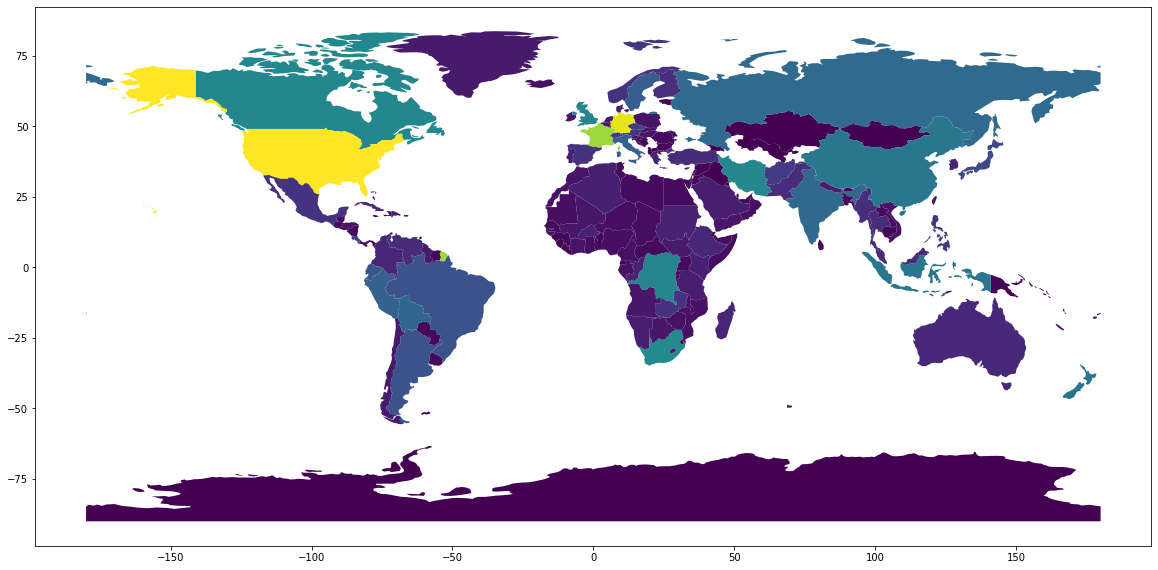

In [ ]:
joined_df.plot(column='airports', figsize=(20, 20));

## Dissolving
* Groupby can perform aggregations across one or more levels
* Dissolve is groupby that both creates aggregations and merges geometries

In [ ]:
joined_df.groupby('continent').agg({'airports': np.sum})

,airports
continent,
Africa,1764
Antarctica,3
Asia,1930
Europe,2738
North America,1301
Oceania,373
Seven seas (open ocean),38
South America,1027


,geometry,pop_est,gdp_md_est,airports
continent,,,,
Africa,"MULTIPOLYGON (((32.830 -26.742, 32.580 -27.470...",1212654066,6015220.0,1764
Antarctica,"MULTIPOLYGON (((-163.713 -78.596, -163.713 -78...",4050,810.0,3
Asia,"MULTIPOLYGON (((120.295 -10.259, 118.968 -9.55...",4326738061,55037647.0,1930
Europe,"MULTIPOLYGON (((-51.658 4.156, -52.249 3.241, ...",678397514,24499707.0,2738
North America,"MULTIPOLYGON (((-61.680 10.760, -61.105 10.890...",573042112,23505137.0,1301
Oceania,"MULTIPOLYGON (((169.668 -43.555, 170.525 -43.0...",36782844,1412885.0,373
Seven seas (open ocean),"POLYGON ((68.935 -48.625, 69.580 -48.940, 70.5...",140,16.0,38
South America,"MULTIPOLYGON (((-66.960 -54.897, -67.291 -55.3...",418540749,6377091.8,1027


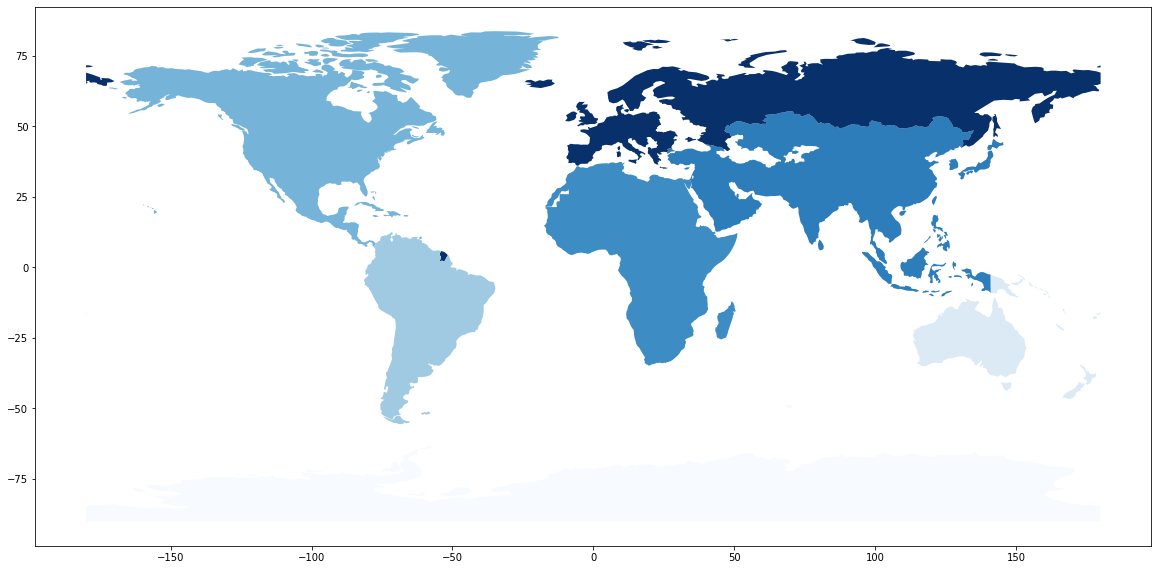

In [ ]:
continents = joined_df.dissolve(by='continent', aggfunc='sum')
continents.plot(column = 'airports', cmap='Blues', figsize=(20, 20));
continents

## Projections

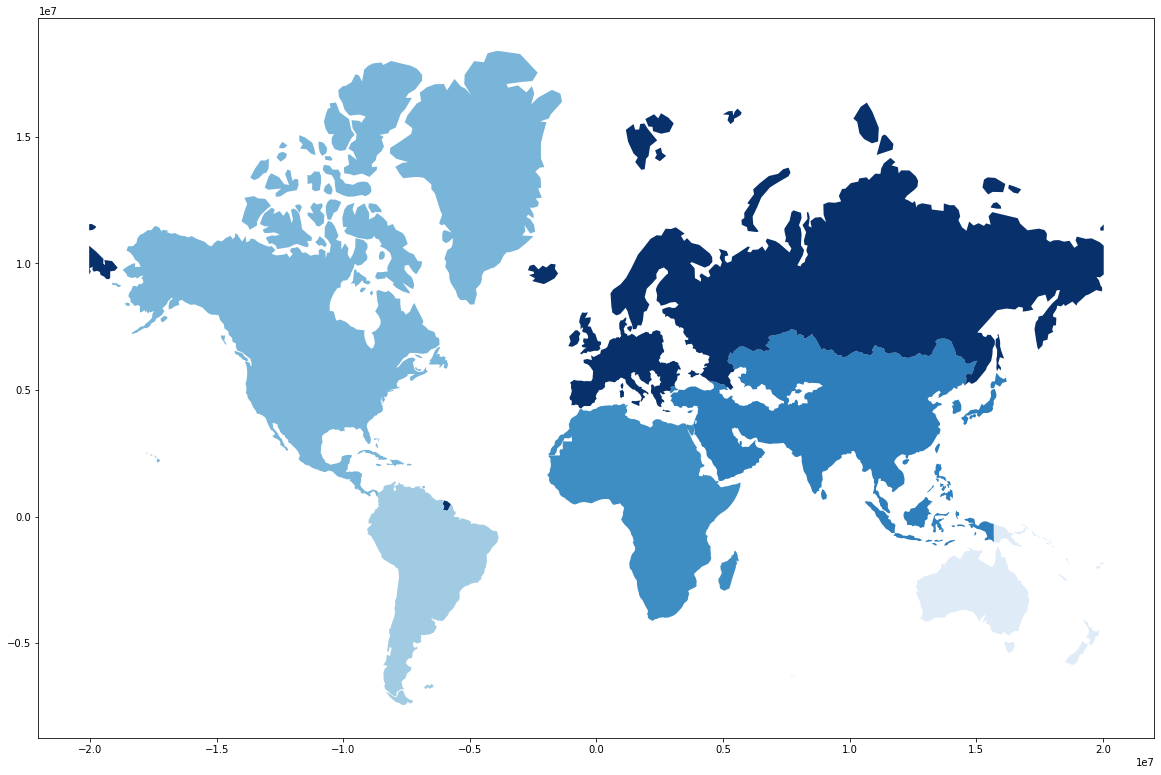

In [ ]:
# Project to Mercator
continents_mercator = continents.to_crs(epsg=3395)
continents_mercator = continents_mercator.drop(labels=['Antarctica'])
continents_mercator.plot(column = 'airports', cmap='Blues', figsize=(20, 20));

## Exporting

In [ ]:
# Write to shapefile
continents.to_file("continents.shp")

In [ ]:
# Write to geojson
continents.to_file("continents.geojson", driver='GeoJSON')

In [ ]:
!head continents.geojson

{
"type": "FeatureCollection",
"crs": { "type": "name", "properties": { "name": "urn:ogc:def:crs:OGC:1.3:CRS84" } },
"features": [
{ "type": "Feature", "properties": { "continent": "Africa", "pop_est": 1212654066, "gdp_md_est": 6015220.0, "airports": 1764 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ 32.830120477028885, -26.742191664336197 ], [ 32.580264926897684, -27.470157566031816 ], [ 32.462132602678452, -28.301011244420557 ], [ 32.203388706193039, -28.752404880490069 ], [ 31.521001417778876, -29.257386976846256 ], [ 31.325561150851001, -29.401977634398914 ], [ 30.901762729625347, -29.909956963828037 ], [ 30.622813348113819, -30.423775730106129 ], [ 30.055716180142781, -31.140269463832958 ], [ 28.925552605919538, -32.172041110972501 ], [ 28.2197558936771, -32.771952813448856 ], [ 27.464608188595975, -33.226963799778801 ], [ 26.419452345492825, -33.614950453426189 ], [ 25.909664340933489, -33.667040297176399 ], [ 25.780628289500697, -33.944646091448341 ], [ 25.1728

# Crime

## Data

In [ ]:
!wget -O crime.json https://data.ferndalemi.gov/datasets/cbaef4e3b93749078a66214bdf0c06d3_0.geojson?outSR=%7B%22latestWkid%22%3A2898%2C%22wkid%22%3A2898%7D

--2021-09-22 11:22:28--  https://data.ferndalemi.gov/datasets/cbaef4e3b93749078a66214bdf0c06d3_0.geojson?outSR=%7B%22latestWkid%22%3A2898%2C%22wkid%22%3A2898%7D
Resolving data.ferndalemi.gov (data.ferndalemi.gov)... 54.173.5.111, 3.221.237.163, 3.227.89.171
Connecting to data.ferndalemi.gov (data.ferndalemi.gov)|54.173.5.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/json]
Saving to: ‘crime.json’

crime.json              [ <=>                ]   8.26M  45.7MB/s    in 0.2s    

2021-09-22 11:22:29 (45.7 MB/s) - ‘crime.json’ saved [8657827]



In [ ]:
!head crime.json

{
"type": "FeatureCollection",
"name": "5b6d7f39-a7c5-4944-b320-87619a527cbf2020329-1-fwnp3o.m0wgm",
"crs": { "type": "name", "properties": { "name": "urn:ogc:def:crs:OGC:1.3:CRS84" } },
"features": [
{ "type": "Feature", "properties": { "OBJECTID": 1, "GEOID10": "260992637001008", "Sum_ViolentCrime": 0, "Sum_PropertyCrime": 0, "Shape__Area": 274648.376953125, "Shape__Length": 2473.7285379674499 }, "geometry": { "type": "Polygon", "coordinates": [ [ [ -83.045476152374107, 42.447722644197697 ], [ -83.046171154742495, 42.447699643364501 ], [ -83.046463154832693, 42.447689643339601 ], [ -83.0465451561804, 42.447687643255101 ], [ -83.046650151380305, 42.450288649624298 ], [ -83.045571148385804, 42.450315651020802 ], [ -83.045476152374107, 42.447722644197697 ] ] ] } },
{ "type": "Feature", "properties": { "OBJECTID": 2, "GEOID10": "260992636004011", "Sum_ViolentCrime": 0, "Sum_PropertyCrime": 0, "Shape__Area": 14154.162109375, "Shape__Length": 1195.6836813362199 }, "geometry": { "type": "Po

## GeoJSON

In [ ]:
crime_df = geopandas.read_file('crime.json')
crime_df

,OBJECTID,GEOID10,Sum_ViolentCrime,Sum_PropertyCrime,Shape__Area,Shape__Length,geometry
0,1,260992637001008,0,0,274648.376953,2473.728538,"POLYGON ((-83.04548 42.44772, -83.04617 42.447..."
1,2,260992636004011,0,0,14154.162109,1195.683681,"POLYGON ((-83.08128 42.44706, -83.08338 42.447..."
2,3,260992637003000,0,0,837251.377930,6179.826759,"POLYGON ((-83.05370 42.45249, -83.05363 42.451..."
3,4,260992589003004,2,4,711877.369629,4750.425846,"POLYGON ((-82.97049 42.45222, -82.97046 42.451..."
4,5,260992683003009,0,0,247560.634277,2068.328411,"POLYGON ((-82.98565 42.44928, -82.98688 42.449..."
...,...,...,...,...,...,...,...
13517,13518,261635166002015,0,0,3239.936768,227.949256,"POLYGON ((-83.02311 42.33896, -83.02329 42.338..."
13518,13519,261635166002022,1,0,12952.829590,647.180788,"POLYGON ((-83.02264 42.33824, -83.02299 42.338..."
13519,13520,261635165001015,0,1,241451.833252,2094.821791,"POLYGON ((-83.01264 42.34084, -83.01310 42.340..."
13520,13521,261635392006001,0,0,54660.828125,2603.332629,"POLYGON ((-83.19580 42.44490, -83.19618 42.444..."


## EDA

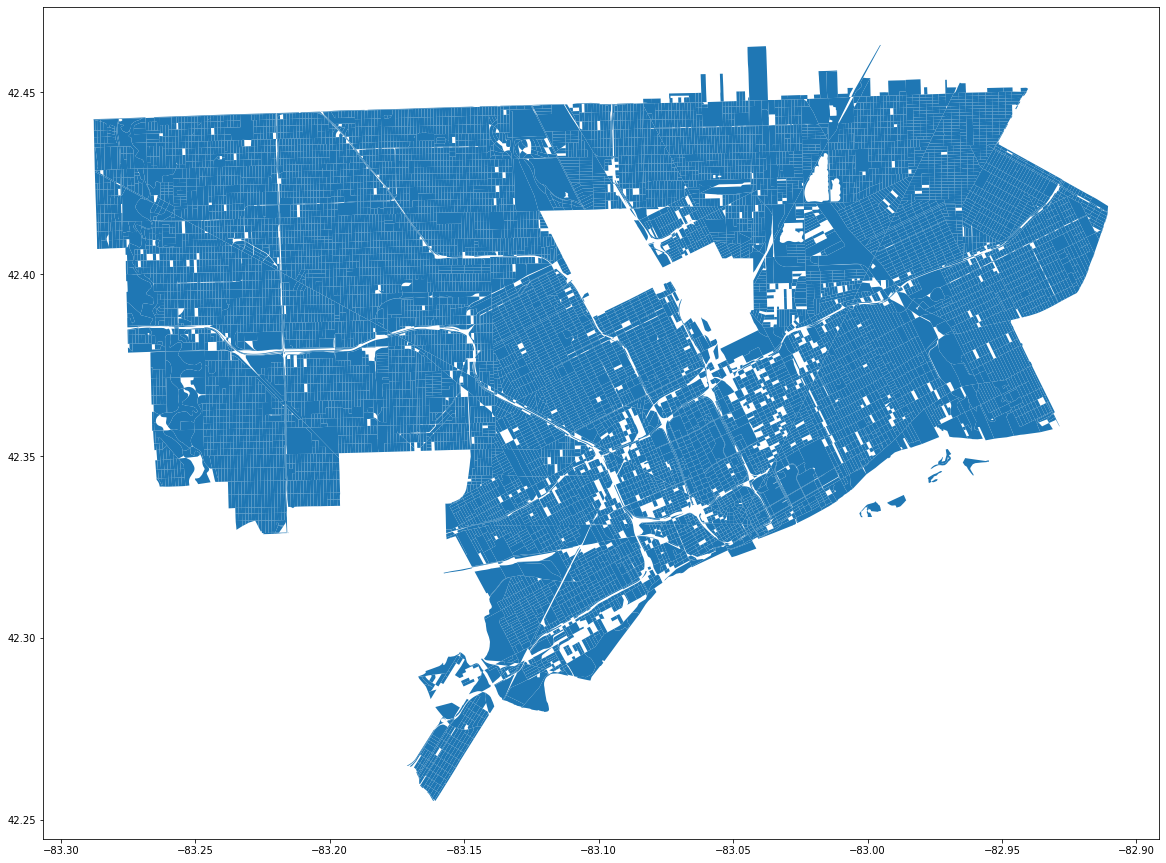

In [ ]:
crime_df.plot(figsize=(20, 20))

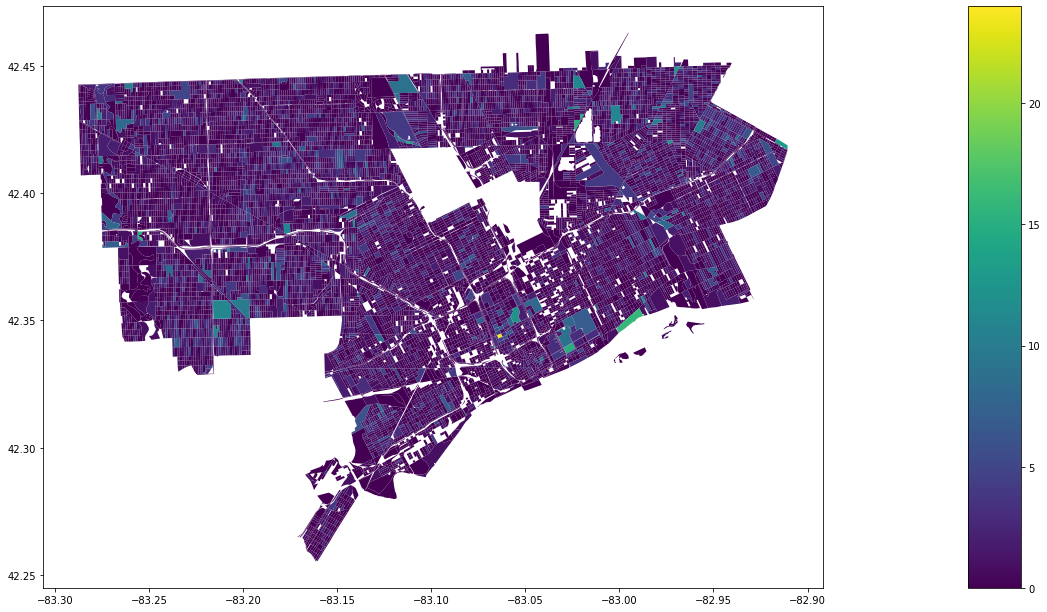

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
crime_df.plot('Sum_ViolentCrime', legend=True, cmap='viridis', ax=ax, cax=cax)

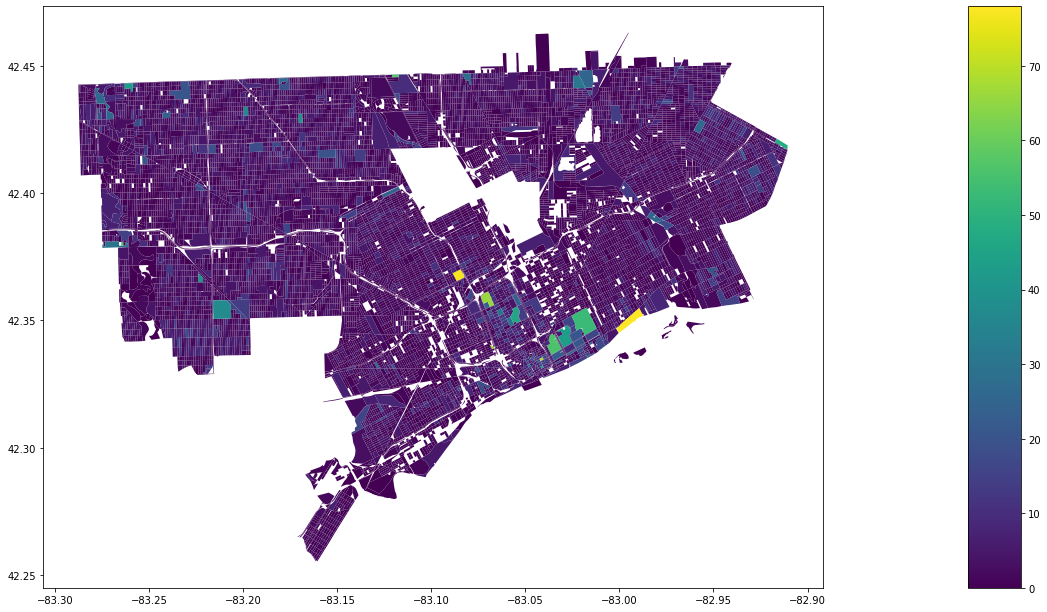

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
crime_df.plot('Sum_PropertyCrime', legend=True, cmap='viridis', ax=ax, cax=cax)

# Clustering
* Finds natural groupings in the data
* Useful when our data doesn't have labels
* KMeans Algorithm
  * Initialize
    * Given k number of clusters
    * Randomly assign each cluster to a point in space (called a centroid)
  * Until convergence:
    * Assign each point to the nearest centroid
    * Update each cluster's centroid based on the data points assigned to it
  * Converge when points don't change clusters
* Important Issues
  * You have to decide how many clusters are in the data
  * You need to scale the values being used (i.e. distance is euclidean)
  * Because clusters are randomly assigned during initiatlization, there will be differences between runs of KMeans

![](https://i.imgur.com/k4XcapI.gif)

# Clustering Geography

## Data Prep

In [ ]:
# Centroid gets us the central geometric (point) for each row's geometry
crime_df.centroid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


0        POINT (-83.04606 42.44901)
1        POINT (-83.08268 42.44717)
2        POINT (-83.05420 42.45124)
3        POINT (-82.96952 42.45093)
4        POINT (-82.98691 42.44976)
                    ...            
13517    POINT (-83.02325 42.33899)
13518    POINT (-83.02300 42.33863)
13519    POINT (-83.01335 42.34151)
13520    POINT (-83.19854 42.44483)
13521    POINT (-83.07170 42.35440)
Length: 13522, dtype: geometry

In [ ]:
def lat_lon(point):
    return (point.x, point.y)
lon, lat = [list(t) for t in zip(*map(lat_lon, crime_df['geometry'].centroid))]
data_df = pd.DataFrame(columns=['lat', 'lon'])
data_df['lat'] = lat 
data_df['lon'] = lon
data_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  This is separate from the ipykernel package so we can avoid doing imports until


,lat,lon
0,42.449005,-83.046061
1,42.447168,-83.082685
2,42.451245,-83.054201
3,42.450928,-82.969520
4,42.449762,-82.986912
...,...,...
13517,42.338992,-83.023246
13518,42.338634,-83.022999
13519,42.341512,-83.013347
13520,42.444827,-83.198542


## Preprocess

In [ ]:
ct = ColumnTransformer([
        ('standardize', StandardScaler(), ['lat', 'lon'])
    ], remainder='passthrough')
transformed = ct.fit_transform(data_df)
transformed

array([[ 1.56194322,  0.61762538],
       [ 1.51479884,  0.22624611],
       [ 1.61939499,  0.53063543],
       ...,
       [-1.19591891,  0.96721712],
       [ 1.45473747, -1.01185768],
       [-0.86535659,  0.34366442]])

## KMeans

In [ ]:
cluster = KMeans(n_clusters=5)
fitted = cluster.fit(transformed)

In [ ]:
# Cluster centers are scaled
fitted.cluster_centers_

array([[ 0.84431646, -0.98422741],
       [ 0.87674503,  1.09981759],
       [-1.61314256,  0.03674139],
       [-0.43794904, -0.85502076],
       [-0.48965773,  0.75666569]])

In [ ]:
# Inverse the transformation to get unscaled values
ct.named_transformers_['standardize'].inverse_transform(fitted.cluster_centers_)

array([[ 42.42103454, -83.19595681],
       [ 42.42229851, -83.00093917],
       [ 42.32525017, -83.10041812],
       [ 42.37105568, -83.1838661 ],
       [ 42.36904023, -83.03305012]])

In [ ]:
# Get the assigned clusters
assignment = fitted.predict(transformed)
assignment

array([1, 1, 1, ..., 4, 0, 4], dtype=int32)

In [ ]:
# Update dataframe with clusters - Explanation
crime_clustered_df = geopandas.GeoDataFrame(data_df, 
  geometry=geopandas.points_from_xy(data_df.lon, data_df.lat))
crime_clustered_df['cluster'] = assignment

## Plot

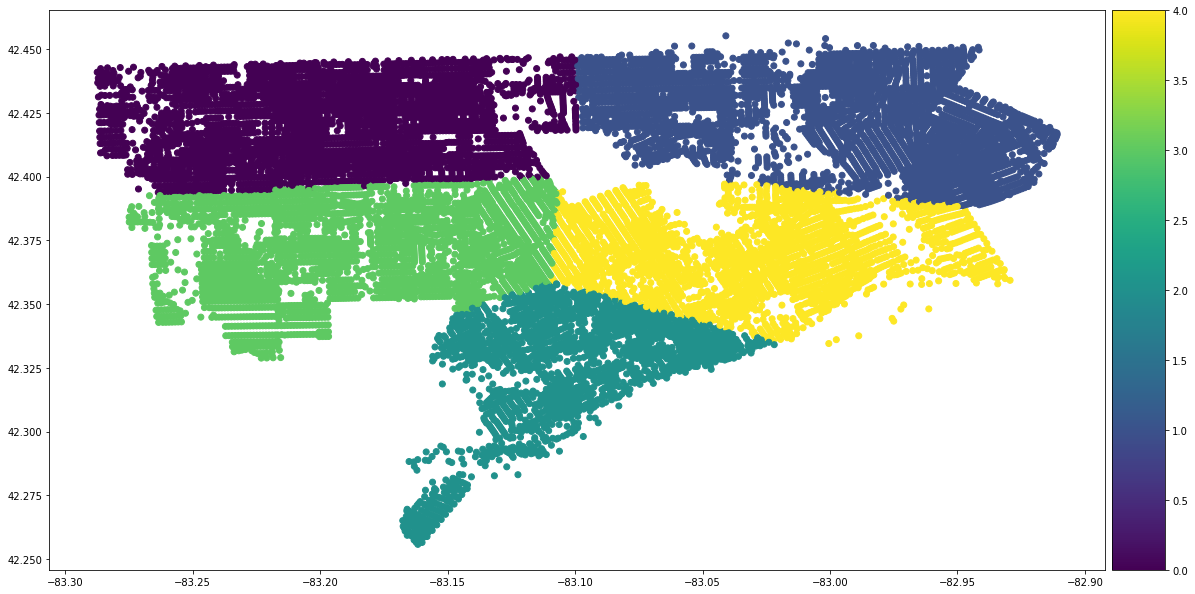

In [ ]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
crime_clustered_df.plot('cluster', cmap='viridis', legend=True, ax=ax, cax=cax)

## Find K
* Intuition for picking the right number of clusters

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


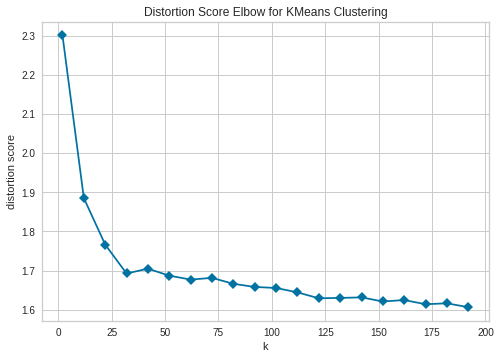

In [ ]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=[x for x in range(2, 202, 10)], timings=False)

visualizer.fit(transformed) # Fit the data to the visualizer
visualizer.poof()           # Finalize and render the figure

## KMeans - Elbow

In [ ]:
# Fit model at the Elbow
cluster = KMeans(n_clusters=25)
fitted = cluster.fit(transformed)

In [ ]:
# Get the assigned clusters
assignment = fitted.predict(transformed)
assignment

array([14, 14, 14, ...,  2, 24,  7], dtype=int32)

In [ ]:
# Update dataframe with clusters - Explanation
crime_clustered_df = geopandas.GeoDataFrame(data_df, 
  geometry=geopandas.points_from_xy(data_df.lon, data_df.lat))
crime_clustered_df['cluster'] = assignment

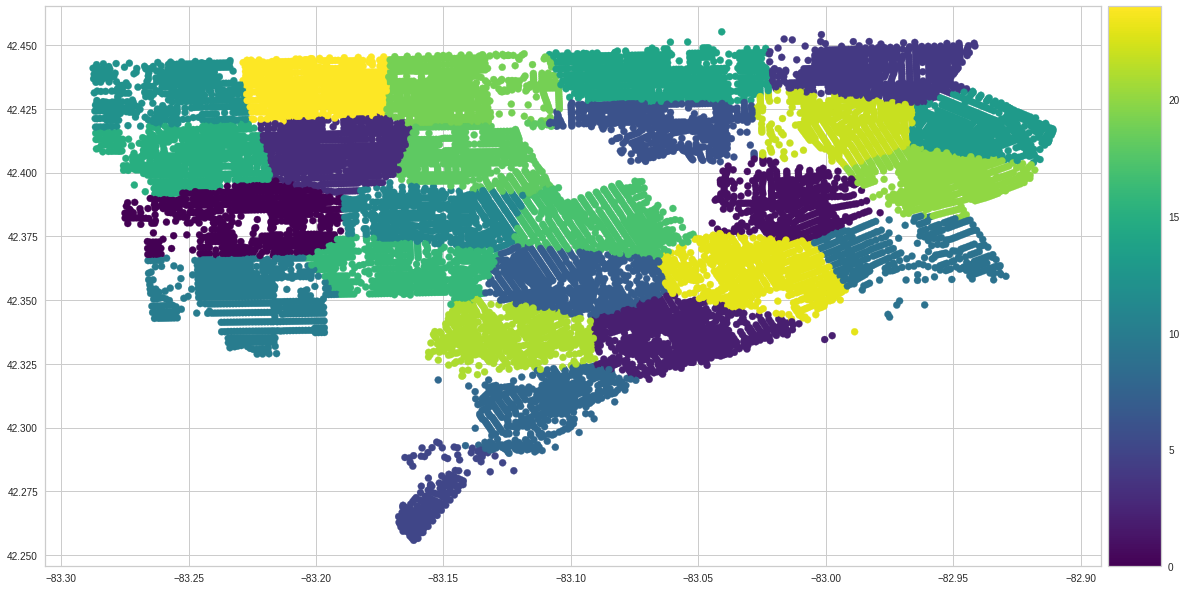

In [ ]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
crime_clustered_df.plot('cluster', cmap='viridis', legend=True, ax=ax, cax=cax)

# Clustering Crime

In [ ]:
def lat_lon(point):
    return (point.x, point.y)
lon, lat = [list(t) for t in zip(*map(lat_lon, crime_df['geometry'].centroid))]
data_df = pd.DataFrame(columns=['lat', 'lon', 'violent', 'property'])
data_df['lat'] = lat 
data_df['lon'] = lon
data_df['violent']  = crime_df.Sum_ViolentCrime
data_df['property'] = crime_df.Sum_PropertyCrime
data_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  This is separate from the ipykernel package so we can avoid doing imports until


,lat,lon,violent,property
0,42.449005,-83.046061,0,0
1,42.447168,-83.082685,0,0
2,42.451245,-83.054201,0,0
3,42.450928,-82.969520,2,4
4,42.449762,-82.986912,0,0
...,...,...,...,...
13517,42.338992,-83.023246,0,0
13518,42.338634,-83.022999,1,0
13519,42.341512,-83.013347,0,1
13520,42.444827,-83.198542,0,0


## Preprocess

In [ ]:
ct = ColumnTransformer([
        ('standardize', StandardScaler(), ['lat', 'lon', 'violent', 'property'])
    ], remainder='passthrough')
transformed = ct.fit_transform(data_df)
transformed

array([[ 1.56194322,  0.61762538, -0.62525941, -0.69434411],
       [ 1.51479884,  0.22624611, -0.62525941, -0.69434411],
       [ 1.61939499,  0.53063543, -0.62525941, -0.69434411],
       ...,
       [-1.19591891,  0.96721712, -0.62525941, -0.40383632],
       [ 1.45473747, -1.01185768, -0.62525941, -0.69434411],
       [-0.86535659,  0.34366442, -0.62525941, -0.69434411]])

## KMeans

In [ ]:
cluster = KMeans(n_clusters=4)
fitted = cluster.fit(transformed)

In [ ]:
# Cluster centers are scaled
fitted.cluster_centers_

array([[-1.1109757 ,  0.06521213, -0.29122284, -0.20302702],
       [-0.03040048, -0.01951935,  2.46078294,  1.92053663],
       [ 0.66436641,  1.08063394, -0.10089695, -0.16167202],
       [ 0.48050193, -1.00410075, -0.15145659, -0.06865009]])

In [ ]:
# Inverse the transformation to get unscaled values
ct.named_transformers_['standardize'].inverse_transform(fitted.cluster_centers_)

array([[ 42.34482312, -83.09775393,   0.47058824,   1.69123553],
       [ 42.3869407 , -83.1056828 ,   4.34759358,   9.00106952],
       [ 42.41402063, -83.00273431,   0.73871795,   1.83358974],
       [ 42.40685414, -83.19781648,   0.6674899 ,   2.15379434]])

In [ ]:
# Get the assigned clusters
assignment = fitted.predict(transformed)
assignment

array([2, 2, 2, ..., 0, 3, 0], dtype=int32)

In [ ]:
# Update dataframe with clusters - Explanation
crime_clustered_df = geopandas.GeoDataFrame(data_df, 
  geometry=geopandas.points_from_xy(data_df.lon, data_df.lat))
crime_clustered_df['cluster'] = assignment

## Plot

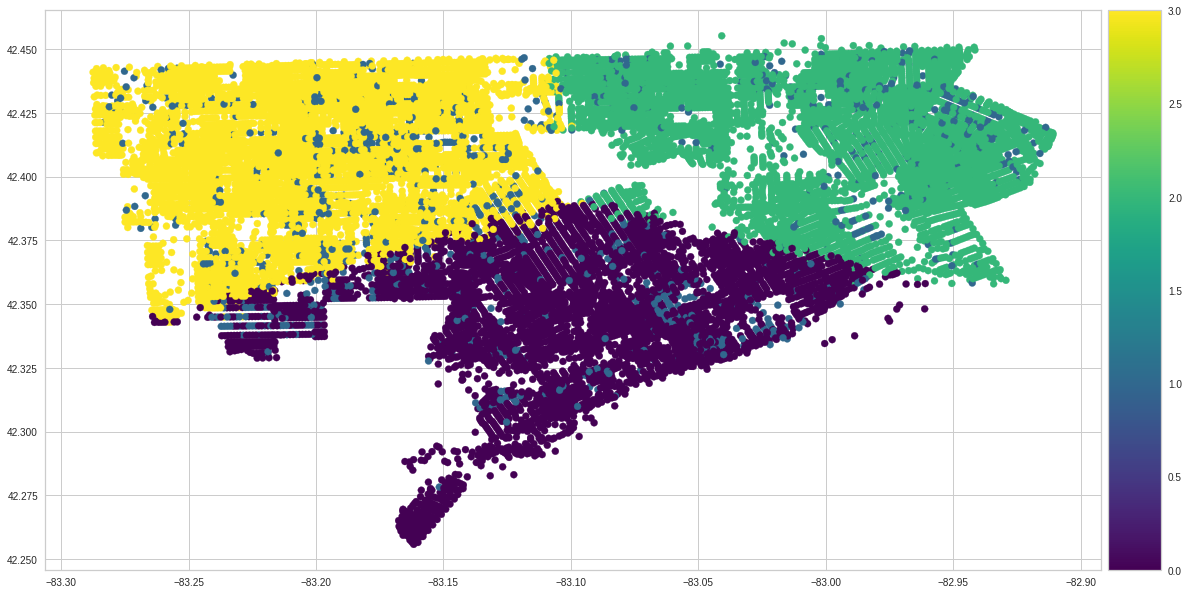

In [ ]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
crime_clustered_df.plot('cluster', cmap='viridis', legend=True, ax=ax, cax=cax)